네이버 영화 리뷰 파일을 이용



In [28]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Kkma, Komoran, Okt

## 형태소 분석기 참고 링크
[링크 텍스트](https://panggu15.github.io/nlp_anal/konlpy_morph/)

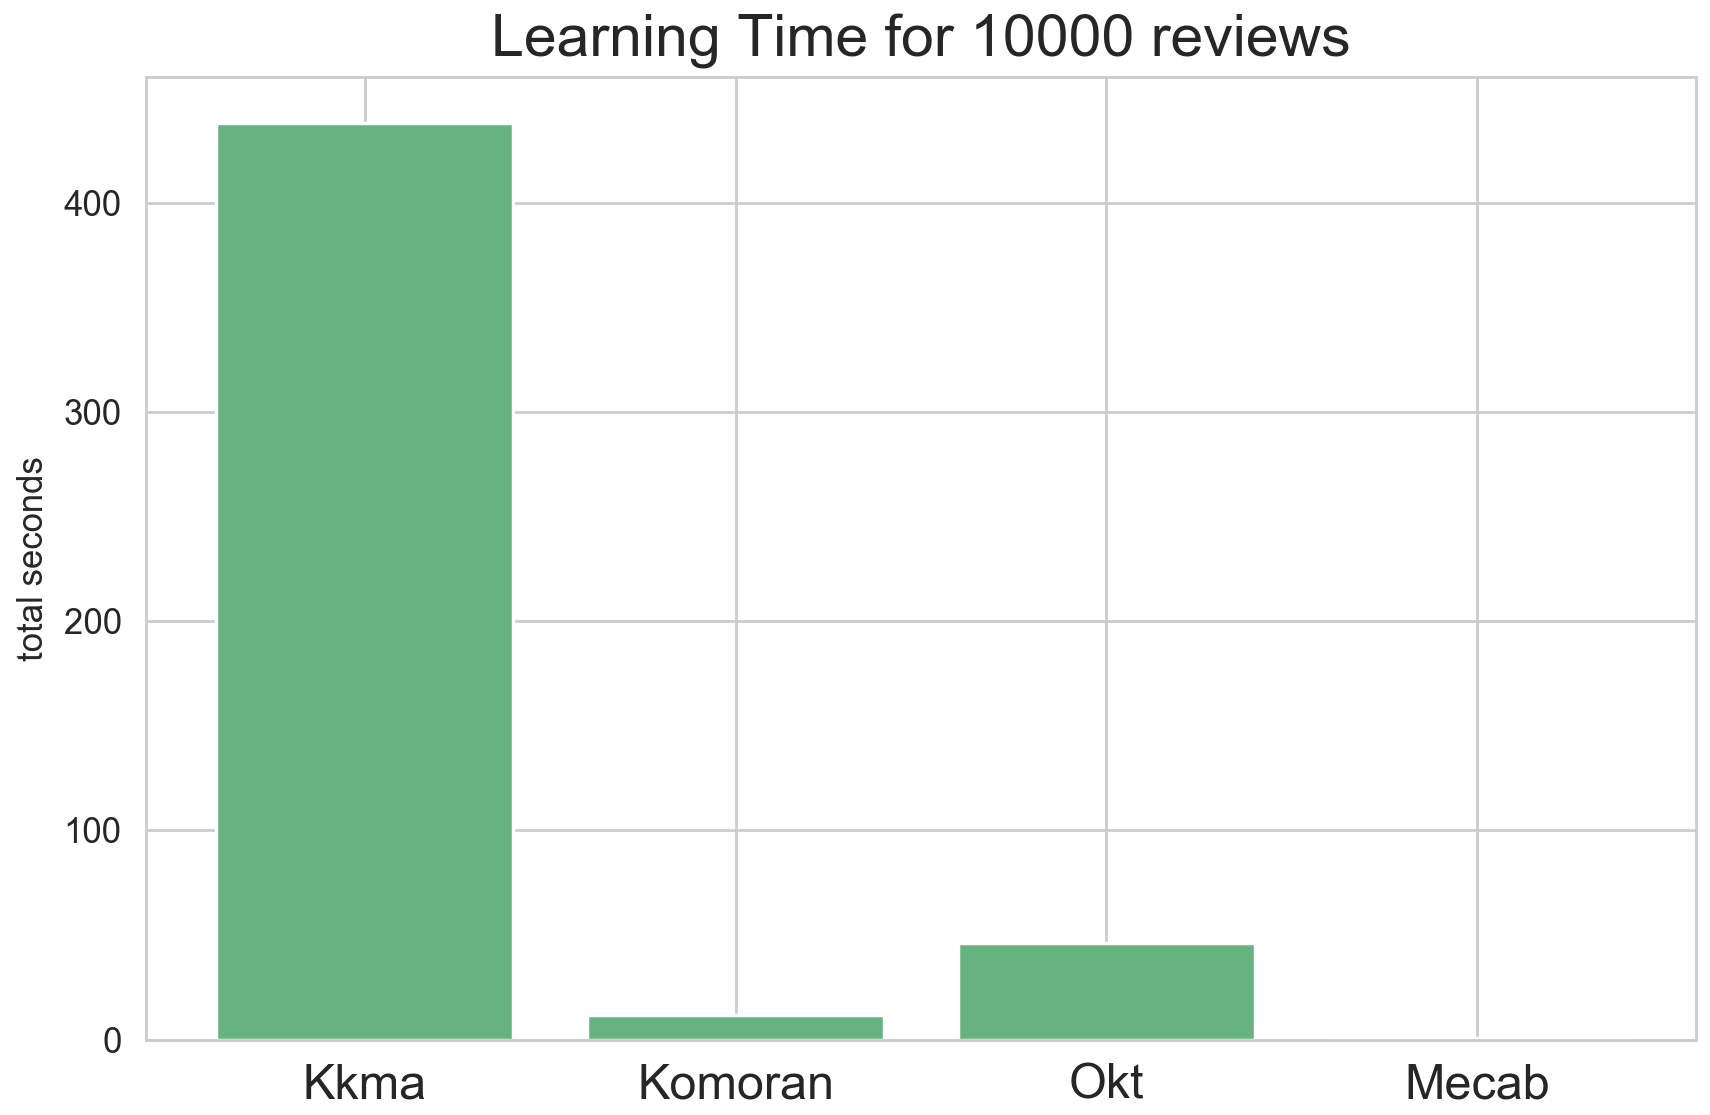

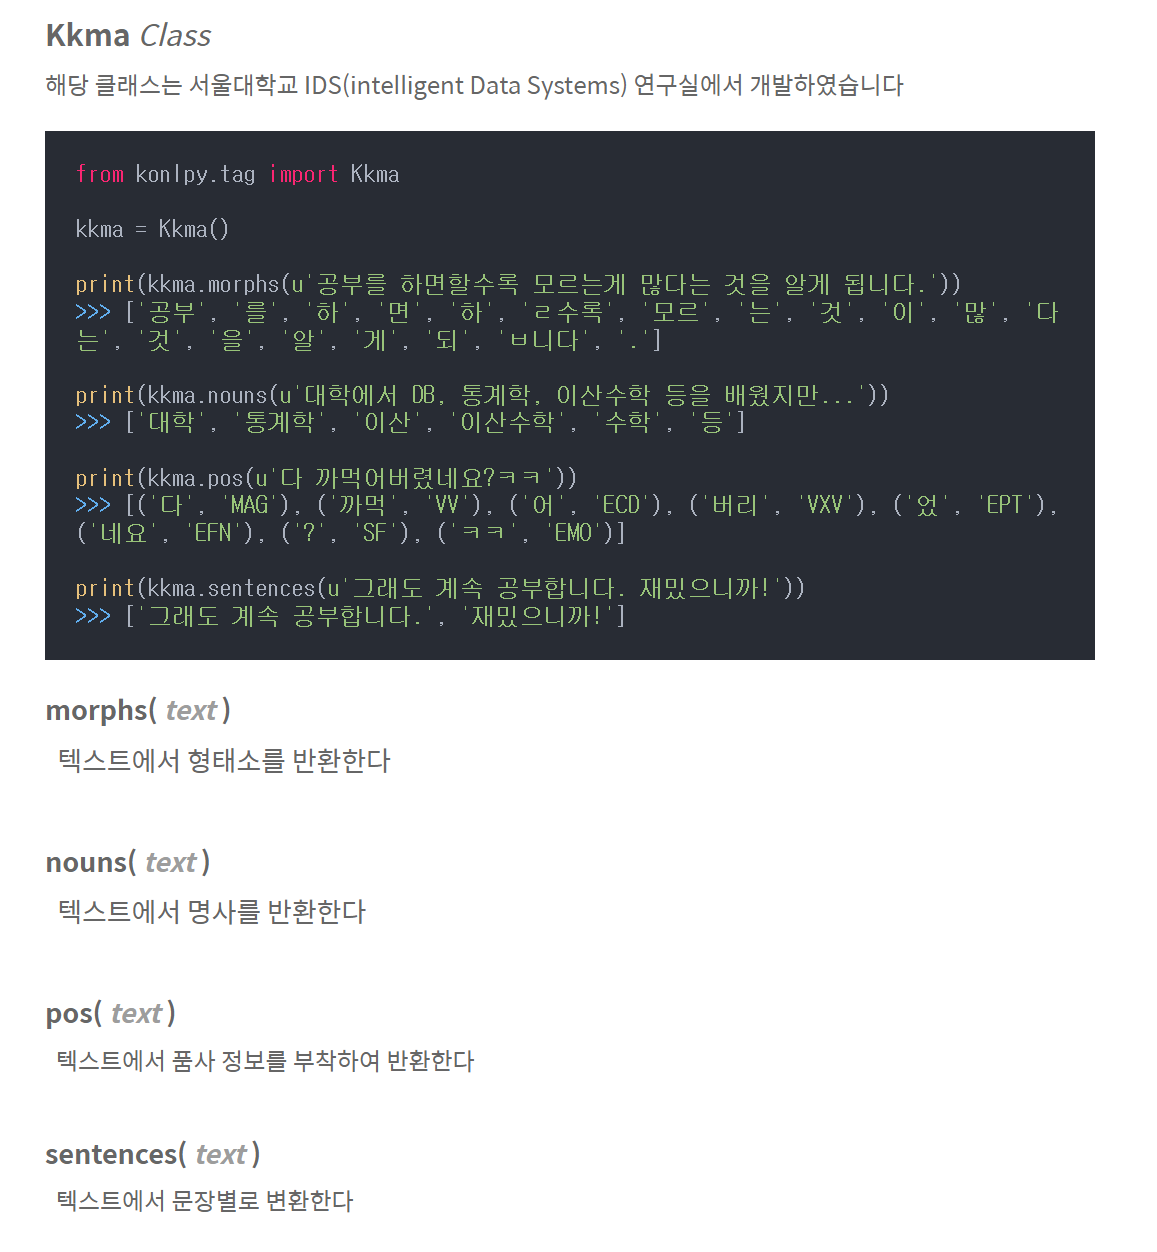

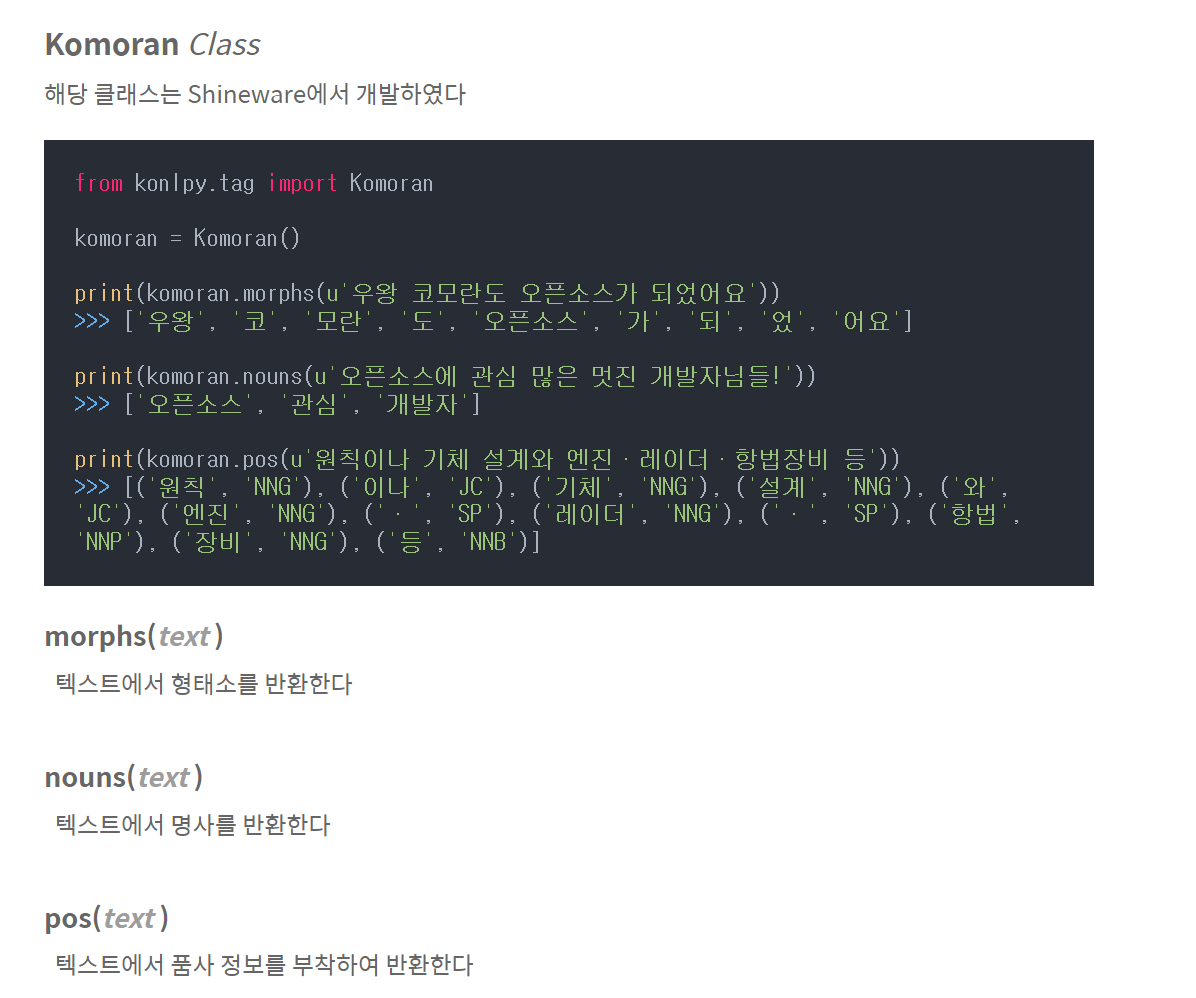

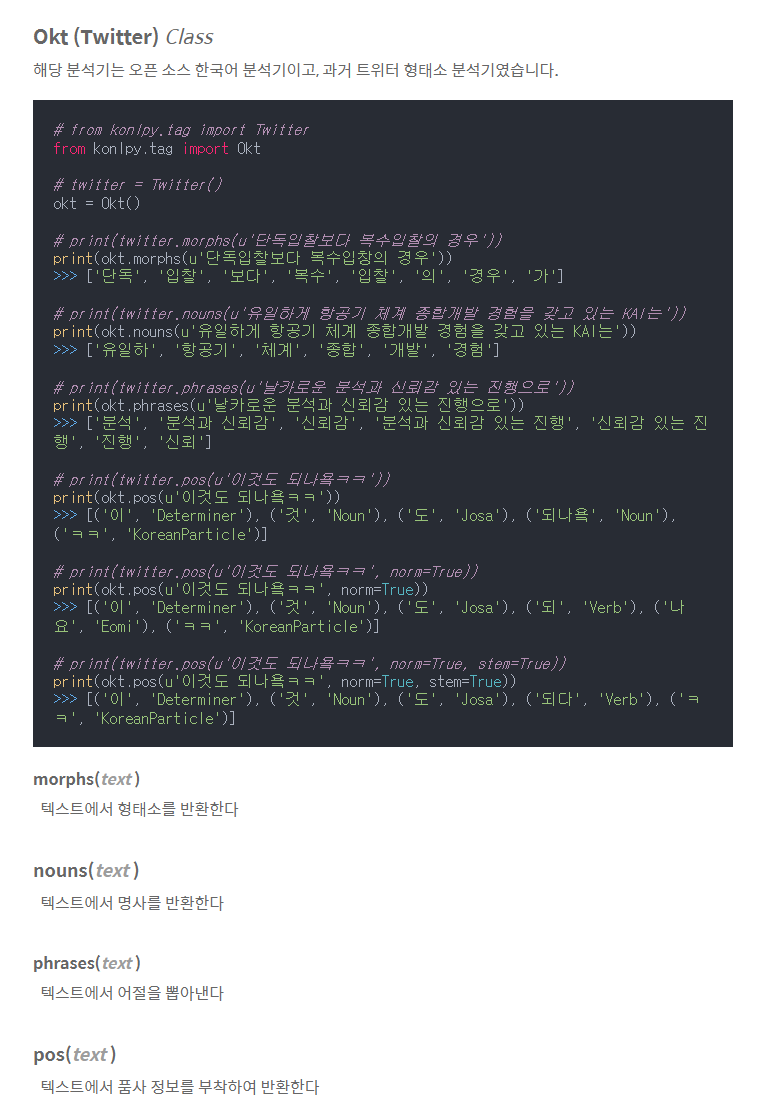

In [ ]:
# # 시간이 너무 오래 걸림 (하지마세요!!)

# # 코랩에서 mecab 깔 때의 코드
# from konlpy.tag import Mecab
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab/
# !bash install_mecab-ko_on_colab190912.sh

# mecab = Mecab()

In [30]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7ff1b4620f10>)

In [31]:
train_data = pd.read_table('ratings.txt')

In [32]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [34]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [35]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [36]:
print(len(train_data)) # 리뷰 개수 출력

199992


In [38]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")

<ipython-input-38-4ea898802ac3>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
<ipython-input-38-4ea898802ac3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")


In [39]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고지금다시봐도재밌어요ㅋㅋ,1
1,8132799,디자인을배우는학생으로외국디자이너와그들이일군전통을통해발전해가는문화산업이부러웠는데사실우...,1
2,4655635,폴리스스토리시리즈는부터뉴까지버릴께하나도없음최고,1
3,9251303,와연기가진짜개쩔구나지루할거라고생각했는데몰입해서봤다그래이런게진짜영화지,1
4,10067386,안개자욱한밤하늘에떠있는초승달같은영화,1


In [40]:
# 불용어 정의
stopwords = ['을', '통해', '의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '그래', '부터', '같은', '게', '이런']

In [41]:
okt = Okt()
kkma = Kkma()
komoran = Komoran()

#### 참고사항: 해당 데이터로 진행 시

#### Kkma는 시간이 너무 오래걸리고, 
#### Komoran은 형태소 분석이 잘 안되어서 명사가 훨씬 더 결과가 깨끗한 편

#### Okt 결과가 그나마 형태소든 명사든 깨끗한 편

#### 데이터마다 다르니 결과가 깔끔하게 토크나이징되는 것으로 해볼 것

In [51]:
# 형태소 분석기로 토큰화 작업 (다소 시간 소요) (형태소 분석기 다양하게 변경해볼 것)
tokenized_data = []
for sentence in train_data['document']:
    temp_X = komoran.nouns(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

In [52]:
tokenized_data[:5] # 상위 5개 출력

[[],
 ['디자인',
  '학생',
  '외국',
  '디자이너',
  '전통',
  '발전',
  '문화',
  '산업',
  '데',
  '사실',
  '우리나라',
  '시절',
  '끝',
  '열정',
  '노라',
  '노',
  '전통',
  '사람',
  '꿈',
  '수',
  '것',
  '감사'],
 ['폴리스', '스토리', '시리즈', '뉴', '최고'],
 ['기가', '진짜', '구', '지루', '할거', '라고', '생각', '몰입', '진짜', '영', '화지'],
 ['안개', '밤하늘', '초승달', '영화']]

Word2vec 훈련

size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원

window = 컨텍스트 윈도우 크기

negative = 네거티브 샘플링할 때 샘플 개수 지정 (0으로 두면 네거티브 샘플링 X, 네거티브 샘플링 진행 시 보통 5~20으로 지정)

min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)

workers = 학습을 위한 프로세스 수

sg = 0은 CBOW, 1은 Skip-gram

In [57]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, negative = 5, min_count = 5, workers = 4, sg = 1)

# negative를 0으로 할 경우와 샘플링할 개수를 지정할 경우의 유사한 데이터 산출 결과를 보면, 결과 차이가 확연하게 드러남

In [58]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(11336, 100)

In [59]:
print(model.wv.most_similar("한석규"))

[('박신양', 0.910748302936554), ('안성기', 0.910298764705658), ('차승원', 0.9099394083023071), ('김민희', 0.9031411409378052), ('황정민', 0.9025998115539551), ('전도연', 0.8960778713226318), ('능청', 0.8909915089607239), ('최민식', 0.8894176483154297), ('김명민', 0.8881068229675293), ('엄태웅', 0.8866587281227112)]


In [60]:
print(model.wv.most_similar("멜로"))

[('정통', 0.8326829671859741), ('로맨스', 0.8007701635360718), ('류의', 0.7824761271476746), ('휴먼', 0.7822795510292053), ('미스터리', 0.7805243730545044), ('느와르', 0.7772983312606812), ('로코', 0.7721923589706421), ('믹', 0.7616821527481079), ('짬뽕', 0.7594952583312988), ('스포츠', 0.7586117386817932)]


사전훈련된 word2vec 불러와서 사용

한국어는 박규병님께서 공개한 Word2Vec 모델이 있다. 해당 깃허브 주소와 모델의 다운로드 링크는 아래와 같다.

GitHub : https://github.com/Kyubyong/wordvectors
모델 다운로드 경로 : https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view
파일의 크기는 약 77MB이고 압축을 풀면 50MV 가량의 ko.bin 파일을 gensim 라이브러리로 로드하면 된다.

In [ ]:
# import gensim
# model2 = gensim.models.Word2Vec.load('ko.bin 파일의 경로')